In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/JWOC/NER/ner_dataset.csv', encoding= 'unicode_escape')

data.fillna(method = 'ffill', inplace = True)
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
ready_data = pd.read_csv('/content/drive/MyDrive/JWOC/NER/ner.csv')
ready_data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [ ]:
def join_a_sentence(sentence_number):
    sentence_number = str(sentence_number)
    the_sentence_words_list = list(data[data['Sentence #'] == 'Sentence: {}'.format(sentence_number)]['Word'])
    
    return ' '.join(the_sentence_words_list)

In [ ]:
join_a_sentence(sentence_number = 3)

'They marched from the Houses of Parliament to a rally in Hyde Park .'

In [ ]:
def num_words_tags (tags, data):
    
    tags_count = {}
    
    for tag in tags:
        len_tag = len(data[data['Tag'] == tag])
        tags_count[tag] = len_tag
    
    return tags_count

In [ ]:
tags = data.Tag.unique()
tags

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [ ]:
tags_count = num_words_tags(tags, data)
tags_count

{'B-art': 402,
 'B-eve': 308,
 'B-geo': 37644,
 'B-gpe': 15870,
 'B-nat': 201,
 'B-org': 20143,
 'B-per': 16990,
 'B-tim': 20333,
 'I-art': 297,
 'I-eve': 253,
 'I-geo': 7414,
 'I-gpe': 198,
 'I-nat': 51,
 'I-org': 16784,
 'I-per': 17251,
 'I-tim': 6528,
 'O': 887908}

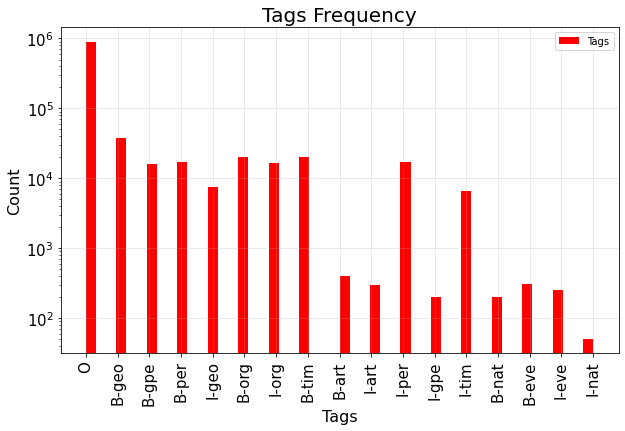

In [ ]:
plt.figure(figsize = (10, 6))
plt.hist(data.Tag, log = True, label = 'Tags', color = 'red', bins = 50)
plt.xlabel('Tags', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title("Tags Frequency", fontsize = 20)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
X = list(ready_data['Sentence'])
Y = list(ready_data['Tag'])

In [ ]:
from ast import literal_eval
Y_ready = []

for sen_tags in Y:
    Y_ready.append(literal_eval(sen_tags))

In [ ]:
maxlen = 110

max_words = 36000


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [ ]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
ind2word = dict([(value, key) for (key, value) in word_index.items()])

Found 27953 unique tokens.


In [ ]:
word2id = word_index

In [ ]:
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

In [ ]:
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [ ]:
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i

In [ ]:
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key

In [ ]:
def preprocess_tags(tags2id, Y_ready):
    
    Y_preprocessed = []
    maxlen = 110
    # for each target 
    for y in Y_ready:
        
        # place holder to store the new preprocessed tag list
        Y_place_holder = []
        
        # for each tag in rhe tag list 
        for tag in y:
            # append the id of the tag in the place holder list
            Y_place_holder.append(tags2id[tag])
        
        # find the lenght of the new preprocessed tag list 
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list
        
        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)
        
    return Y_preprocessed

In [ ]:
Y_preprocessed = preprocess_tags(tags2id, Y_ready)

In [ ]:
print("The Lenght of training examples: {}".format(len(X_preprocessed)))
print("The Lenght of training targets: {}".format(len(Y_preprocessed)))

The Lenght of training examples: 47959
The Lenght of training targets: 47959


In [ ]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

In [ ]:
training_samples = 0.7
# 15% of the datat will be used for validation 
validation_samples = 0.15
# 15% of the datat will be used for testing 
testing_samples = 0.15

In [ ]:
indices = np.arange(len(Y_preprocessed))
np.random.seed(seed=555)
np.random.shuffle(indices)

X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))



Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 33571
Number of validation examples: 7194
Number of testing examples: 7194
Total number of examples after shuffling and splitting: 47959


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
BATCH_SIZE = 132
SHUFFLE_BUFFER_SIZE = 132

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
embedding_dim = 300
maxlen = 110
max_words = 36000
num_tags = len(tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=50, activation='tanh', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=15)

Epoch 1/15
255/255 [==============================] - 357s 1s/step - loss: 0.1977 - accuracy: 0.9658 - val_loss: 0.1157 - val_accuracy: 0.9703
Epoch 2/15
255/255 [==============================] - 345s 1s/step - loss: 0.1025 - accuracy: 0.9719 - val_loss: 0.0878 - val_accuracy: 0.9748
Epoch 3/15
255/255 [==============================] - 344s 1s/step - loss: 0.0738 - accuracy: 0.9774 - val_loss: 0.0723 - val_accuracy: 0.9782
Epoch 4/15
255/255 [==============================] - 342s 1s/step - loss: 0.0590 - accuracy: 0.9808 - val_loss: 0.0676 - val_accuracy: 0.9796
Epoch 5/15
255/255 [==============================] - 344s 1s/step - loss: 0.0495 - accuracy: 0.9834 - val_loss: 0.0675 - val_accuracy: 0.9801
Epoch 6/15
255/255 [==============================] - 342s 1s/step - loss: 0.0432 - accuracy: 0.9854 - val_loss: 0.0682 - val_accuracy: 0.9805
Epoch 7/15
255/255 [==============================] - 343s 1s/step - loss: 0.0386 - accuracy: 0.9869 - val_loss: 0.0693 - val_accuracy: 0.9805

In [ ]:
model.evaluate(test_dataset)

55/55 [==============================] - 1s 15ms/step - loss: 0.0992 - accuracy: 0.9809


[0.09922036528587341, 0.9808881282806396]